 # Diagnosing CPCN

In [1]:
from types import SimpleNamespace
from functools import partial
import pydove as dv
import matplotlib as mpl

import torch

from tqdm.notebook import tqdm

from cpcn import LinearCPCNetwork, load_mnist, Trainer

 ## Setup

In [2]:
device = torch.device("cpu")

# for reproducibility
torch.manual_seed(123)

# this creates the loaders
batch_size = 100
dataset = load_mnist(
    n_train=5000, n_validation=1000, batch_size=batch_size, device=device
)

 ## Train CPCN

In [3]:
n_epochs = 50
dims = [784, 5, 10]

z_it = 50
z_lr = 0.1

torch.manual_seed(123)

# match the PCN network
g_a = 0.5 * torch.ones(len(dims) - 2)
g_a[-1] *= 2

g_b = 0.5 * torch.ones(len(dims) - 2)
g_b[0] *= 2

net = LinearCPCNetwork(
    dims,
    z_lr=z_lr,
    z_it=z_it,
    g_a=g_a,
    g_b=g_b,
    c_m=0,
    l_s=g_b,
    fast_optimizer=torch.optim.Adam,
    bias_a=False,
    bias_b=False,
)
net = net.to(device)

trainer = Trainer(net, dataset["train"], dataset["validation"])
trainer.set_classifier("linear")

trainer.set_optimizer(torch.optim.Adam, lr=0.001)
# trainer.add_scheduler(partial(torch.optim.lr_scheduler.ExponentialLR, gamma=0.9))

trainer.peek_epoch("weight", ["W_a", "W_b", "Q", "M"])
trainer.peek_sample("latent", ["z"])
trainer.peek_fast_dynamics(
    "fast",
    ["a", "b", "z", "n"],
    condition=lambda epoch, batch: epoch % 50 == 49 and batch == 49,
)

results = trainer.run(n_epochs, progress=tqdm)

  0%|          | 0/50 [00:00<?, ?it/s]

 ## Check convergence of latent variables

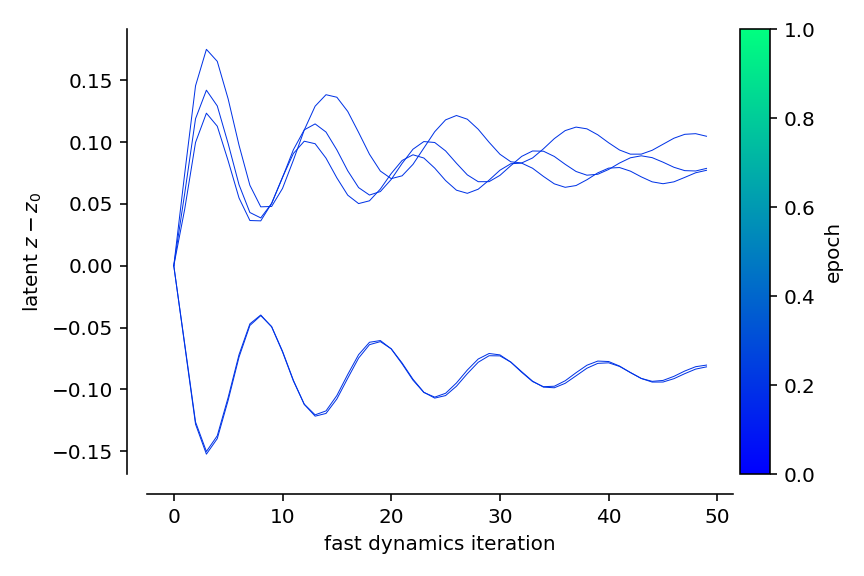

In [4]:
with dv.FigureManager() as (_, ax):
    cmap = mpl.cm.winter
    crt_sel = trainer.history.fast["sample"] == batch_size - 1

    crt_epoch = trainer.history.fast["epoch"][crt_sel]
    crt_z = trainer.history.fast["z:1"][crt_sel]

    n = len(crt_epoch)
    for i in range(n):
        color = cmap(int(cmap.N * (0.2 + 0.8 * i / n)))
        ax.plot(crt_z[i, :, :] - crt_z[i, 0, :], c=color, lw=0.5)

    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=mpl.pyplot.Normalize(vmin=0, vmax=n))
    sm.ax = ax
    cbar = dv.colorbar(sm)
    cbar.set_label("epoch")

    ax.set_xlabel("fast dynamics iteration")
    ax.set_ylabel("latent $z - z_0$")

 ## Check whitening constraint in hidden layer

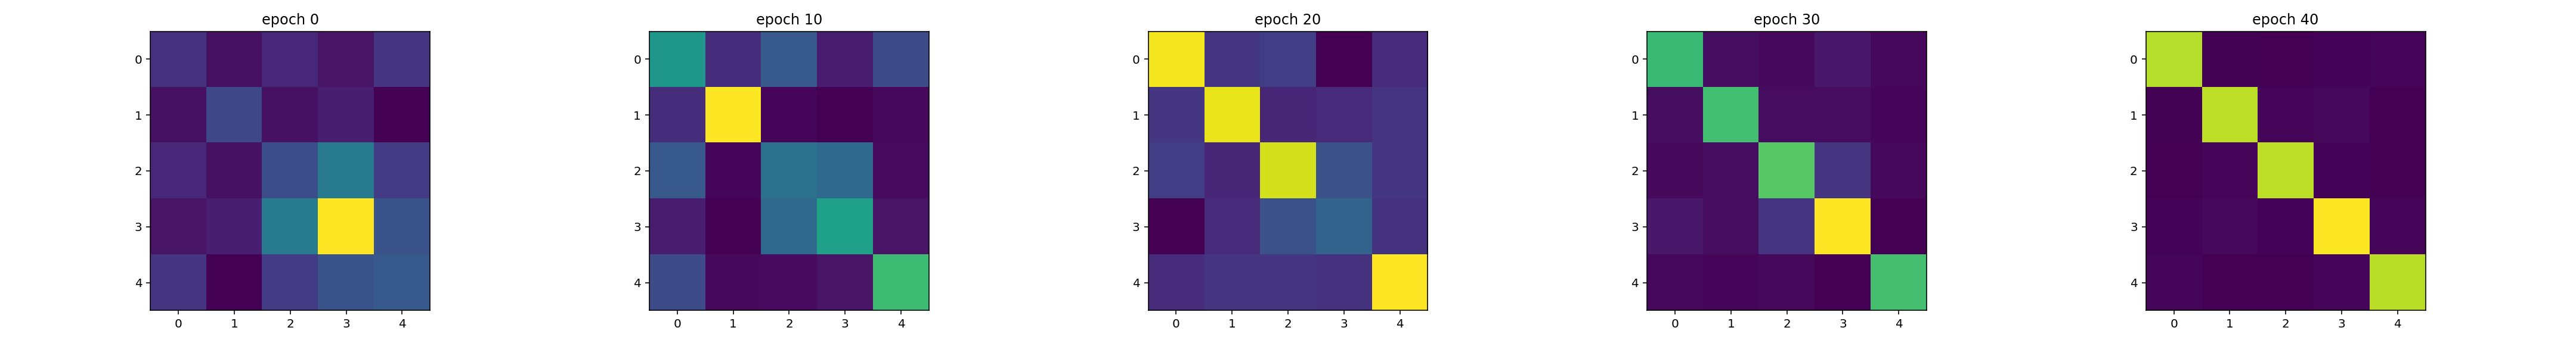

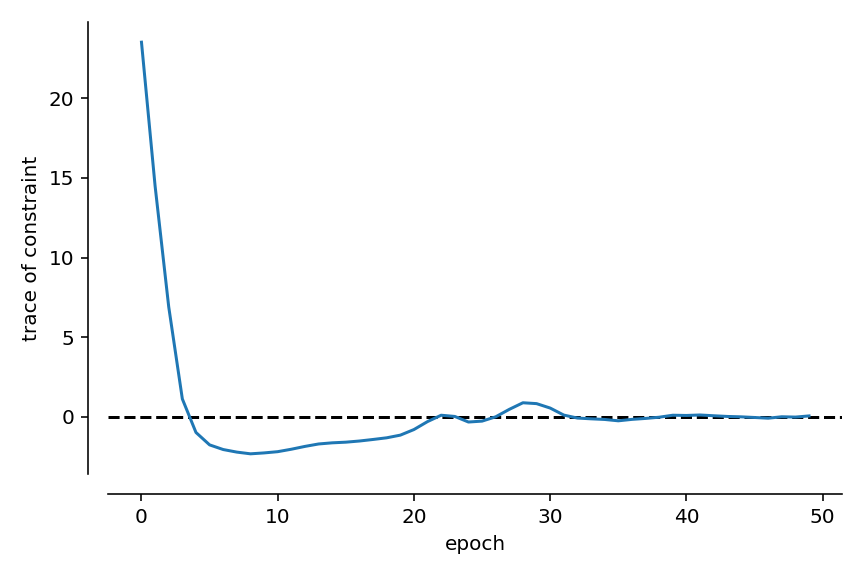

In [5]:
hidden_size = net.pyr_dims[1]
z_cov = torch.zeros((n_epochs, hidden_size, hidden_size))
for epoch in range(n_epochs):
    crt_sel = trainer.history.latent["epoch"] == epoch
    crt_z = trainer.history.latent["z:1"][crt_sel]

    z_cov[epoch] = crt_z.T @ crt_z / len(crt_z)

tr_cons = [torch.trace(z_cov[i] - torch.eye(hidden_size)) for i in range(n_epochs)]
sel_epochs = list(range(0, n_epochs, int(n_epochs / 5)))
with dv.FigureManager(1, len(sel_epochs), do_despine=False) as (_, axs):
    for ax, epoch in zip(axs, sel_epochs):
        ax.imshow(z_cov[epoch])
        ax.set_title(f"epoch {epoch}")

with dv.FigureManager() as (_, ax):
    ax.axhline(0, c="k", ls="--")
    ax.plot(tr_cons)
    ax.set_xlabel("epoch")
    ax.set_ylabel("trace of constraint")

 ## Show loss and accuracy evolution

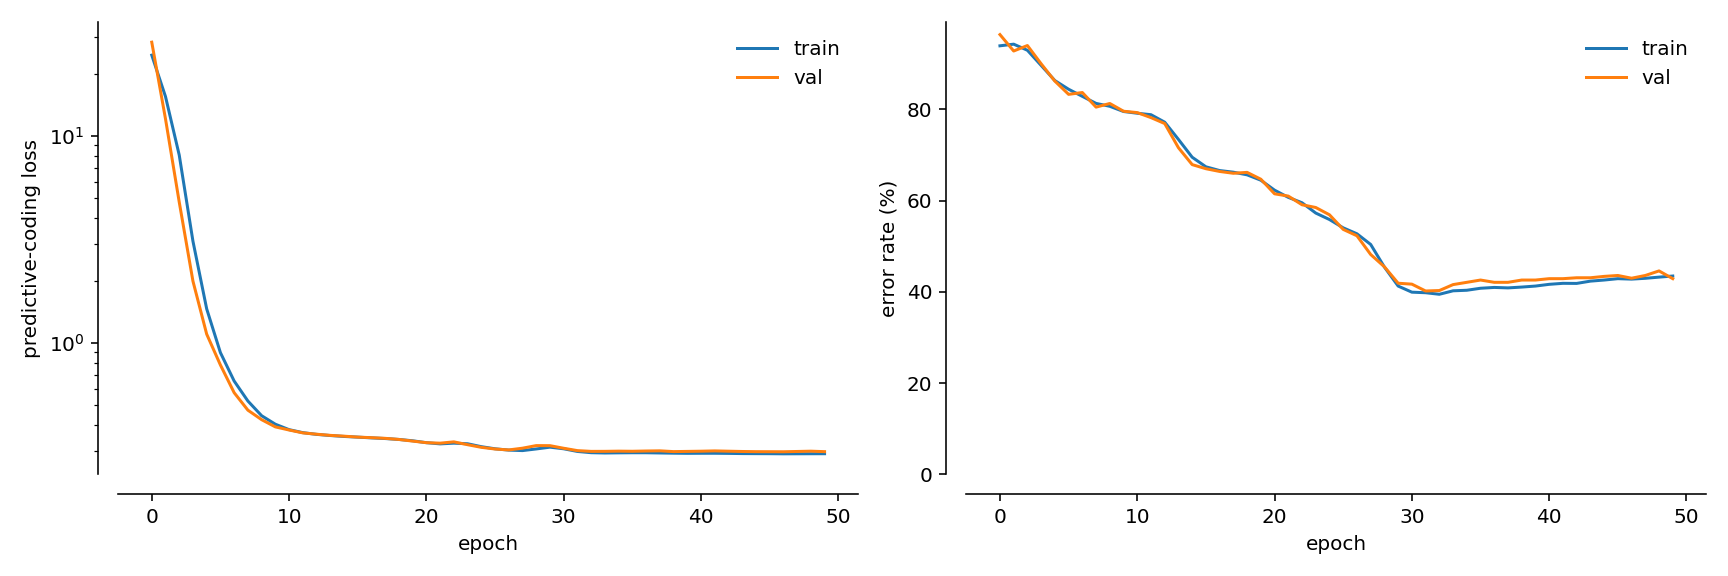

In [6]:
with dv.FigureManager(1, 2) as (_, (ax1, ax2)):
    ax1.plot(results.train.pc_loss, label="train")
    ax1.plot(results.validation.pc_loss, label="val")
    ax1.legend(frameon=False)
    ax1.set_yscale("log")
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("predictive-coding loss")

    ax2.plot(100 * (1.0 - results.train.accuracy), label="train")
    ax2.plot(100 * (1.0 - results.validation.accuracy), label="val")
    ax2.legend(frameon=False)
    ax2.set_ylim(0, None)
    ax2.set_xlabel("epoch")
    ax2.set_ylabel("error rate (%)")

 ## Check weight evolution

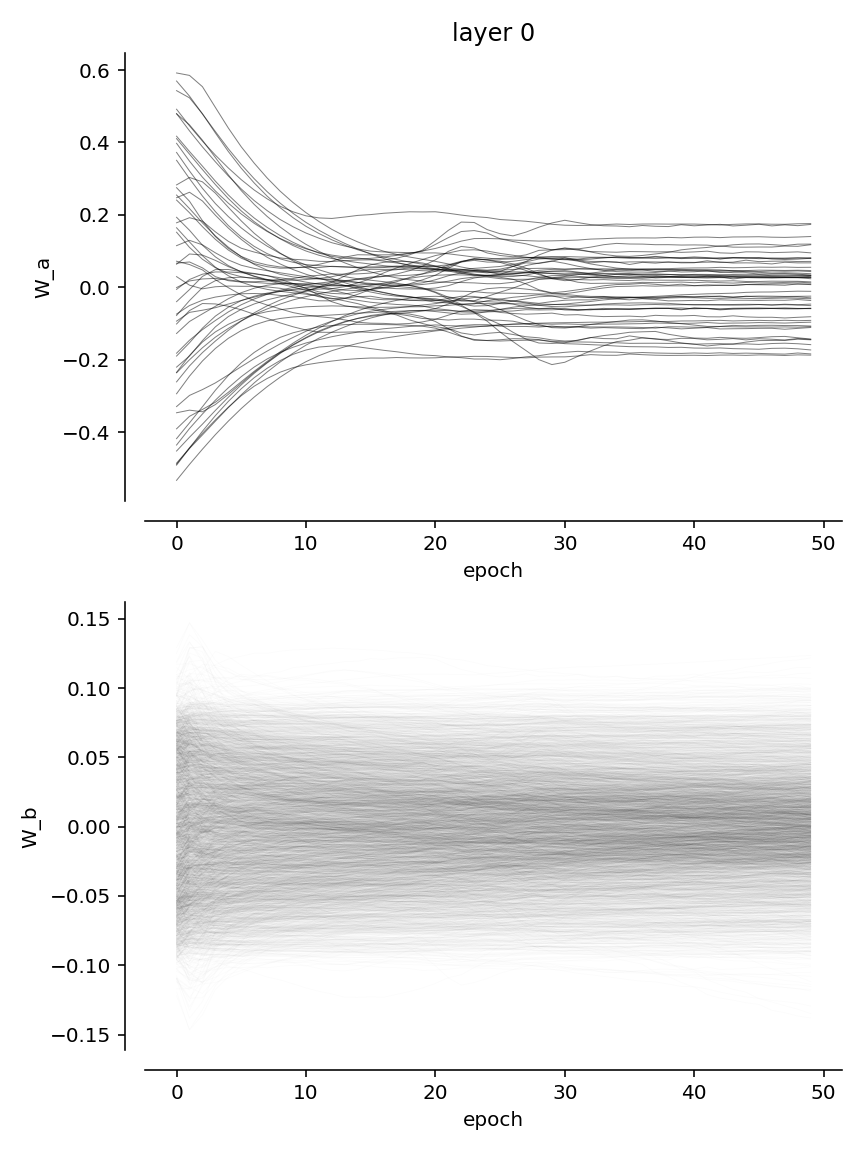

In [7]:
D = len(net.inter_dims)
with dv.FigureManager(2, D, squeeze=False) as (_, axs):
    for ax_row, w_choice in zip(axs, ["W_a", "W_b"]):
        for k, ax in enumerate(ax_row):
            crt_data = trainer.history.weight[f"{w_choice}:{k}"].reshape(n_epochs, -1)
            n_lines = crt_data.shape[1]
            alpha = max(min(50 / n_lines, 0.5), 0.01)
            ax.plot(crt_data, c="k", lw=0.5, alpha=alpha)

            ax.set_xlabel("epoch")
            ax.set_ylabel(w_choice)

            if w_choice == "W_a":
                ax.set_title(f"layer {k}")